# CNN Interpretation - Image Generation

Note: This notebook is desinged to run with Python3 and GPU runtime.

![Python 3 and CPU runtime](https://raw.githubusercontent.com/enakai00/colab_tfbook/master/docs/imgs/runtime_gpu.png)

In [1]:
%%bash
tf_version='2.0.0rc0'
if pip freeze | grep -q "^tensorflow==${tf_version}$"; then
    echo "tensorflow==${tf_version} is already installed. No actions are required."
else
    echo "Installing tensorflow==${tf_version}. Don't forget to restart the runtime."
    pip install tensorflow==${tf_version}
fi

tensorflow==2.0.0rc0 is already installed. No actions are required.


####[CII-01]
Import modules and set a random seed.

In [0]:
import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

np.random.seed(20190225)
tf.random.set_seed(20190225)

####[CII-02]
Define a function to generate random images that maximize the outputs from filters.

In [0]:
def gen_pattern(model_input, layer_ouput, filter_index):
    mean_output = K.mean(layer_output[:, :, :, filter_index])
    grads = K.gradients(mean_output, model_input)[0]
    grads_vals = K.function([model_input], [grads])

    input_image = normal(0.5, 0.1, 28*28).reshape([1, 28*28])
    epsilon = 1000
    for _ in range(20):
        input_image += epsilon * grads_vals([input_image])[0]
        epsilon *= 0.9

    image = input_image[0]
    image -= np.min(image)
    image /= np.max(image)
    return image

####[CII-03]
Define a model with fixed filters.

In [4]:
def edge_filter(shape=None, dtype=None):
    filter0 = np.array(
            [[ 2, 1, 0,-1,-2],
             [ 3, 2, 0,-2,-3],
             [ 4, 3, 0,-3,-4],
             [ 3, 2, 0,-2,-3],
             [ 2, 1, 0,-1,-2]]) / 23.0
    filter1 = np.array(
            [[ 2, 3, 4, 3, 2],
             [ 1, 2, 3, 2, 1],
             [ 0, 0, 0, 0, 0],
             [-1,-2,-3,-2,-1],
             [-2,-3,-4,-3,-2]]) / 23.0
    
    filter_array = np.zeros([5, 5, 1, 2])
    filter_array[:, :, 0, 0] = filter0
    filter_array[:, :, 0, 1] = filter1

    return filter_array

model = models.Sequential()
model.add(layers.Reshape((28, 28, 1), input_shape=(28*28,), name='reshape'))
model.add(layers.Conv2D(2, (5, 5), padding='same',
                        kernel_initializer=edge_filter,
                        use_bias=False,
                        name='conv_filter'))
model.add(layers.Lambda(lambda x: abs(x), name='abs'))
model.add(layers.Lambda(lambda x: tf.keras.backend.relu(x-0.2), name='cut_off'))
model.summary()

W0826 11:34:18.064772 140661779855232 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv_filter (Conv2D)         (None, 28, 28, 2)         50        
_________________________________________________________________
abs (Lambda)                 (None, 28, 28, 2)         0         
_________________________________________________________________
cut_off (Lambda)             (None, 28, 28, 2)         0         
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________


####[CII-04]
Generate images that maximize the outputs from the fixed filters.

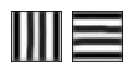

In [5]:
fig = plt.figure(figsize=(2, 1))
layer_output = model.get_layer('cut_off').output
for i in range(layer_output.shape[-1]):
    img = gen_pattern(model.input, layer_output, i)
    subplot = fig.add_subplot(1, 2, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(img.reshape(28, 28), cmap=plt.cm.gray_r)

####[CII-05]
Mount your Google Drive on `/content/gdrive`.

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


####[CII-06]
Confirm that the exported model file `MNIST_double.hd5` is on your Google Drive.

In [7]:
!ls -lh '/content/gdrive/My Drive/MNIST_double.hd5'

-rw------- 1 root root 38M Aug 26 11:32 '/content/gdrive/My Drive/MNIST_double.hd5'


####[CII-07]
Restore the model from the exported model file.

In [8]:
cnn_model = models.load_model('/content/gdrive/My Drive/MNIST_double.hd5')
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv_filter1 (Conv2D)        (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling1 (MaxPooling2D)  (None, 14, 14, 32)        0         
_________________________________________________________________
conv_filter2 (Conv2D)        (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2 (MaxPooling2D)  (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
hidden (Dense)               (None, 1024)              3

####[CII-08]
Generate images that maximize the outputs from the first filters.

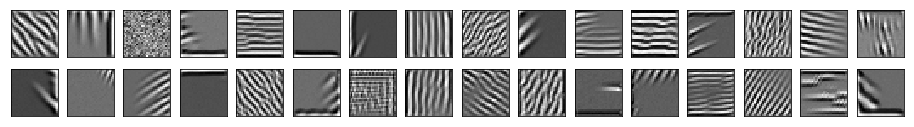

In [9]:
fig = plt.figure(figsize=(16, 2))
layer_output = cnn_model.get_layer('conv_filter1').output
for i in range(layer_output.shape[-1]):
    img = gen_pattern(cnn_model.input, layer_output, i)
    subplot = fig.add_subplot(2, 16, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(img.reshape(28, 28), cmap=plt.cm.gray_r)

####[CII-09]
Generate images that maximize the outputs from the second filters.

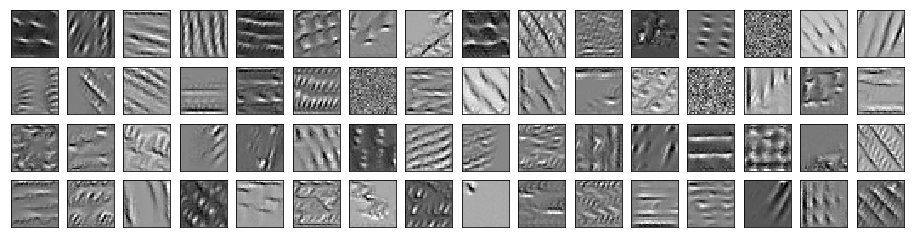

In [10]:
fig = plt.figure(figsize=(16, 4))
layer_output = cnn_model.get_layer('conv_filter2').output
for i in range(layer_output.shape[-1]):
    img = gen_pattern(cnn_model.input, layer_output, i)
    subplot = fig.add_subplot(4, 16, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(img.reshape(28, 28), cmap=plt.cm.gray_r)